## <span style="color:#0066cc; font-weight:bold">EXPLORATORY DATA ANALYSIS ON TICKETS</span>

In [1]:
# Add project root to path 
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

In [2]:
# All imports
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from src.config import DB_URL  
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42
import warnings

sns.set(style="whitegrid")
engine = create_engine(DB_URL)


# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### <span style="color:#4da6ff; font-weight:bold"> TICKET COUNT PER WEEK

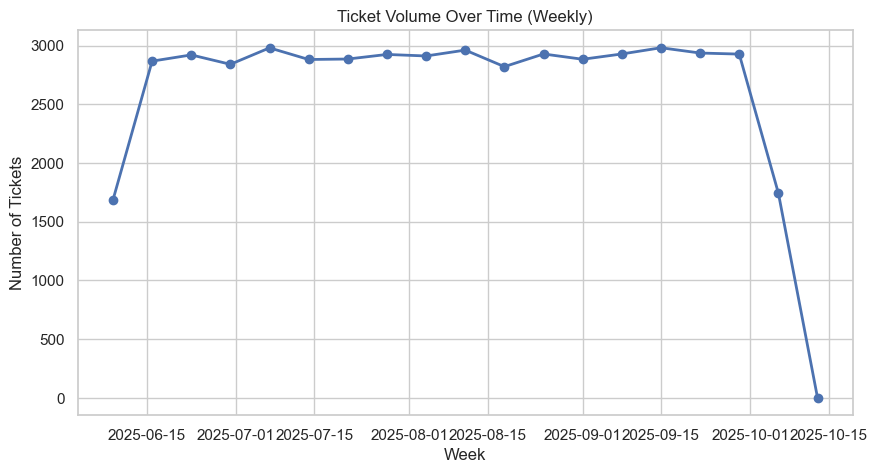

In [3]:
query = text("""
    SELECT 
        DATE_TRUNC('week', created_at) AS week,
        COUNT(*) AS ticket_count
    FROM tickets
    GROUP BY week
    ORDER BY week;
""")

with engine.connect() as conn:
    df_trend = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
plt.plot(df_trend["week"], df_trend["ticket_count"], marker='o', linewidth=2)
plt.title("Ticket Volume Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Number of Tickets")
plt.grid(True)
plt.show()


### <span style="color:#4da6ff; font-weight:bold"> AVERAGE RESOLUTION TIME(h) PER CHANNEL

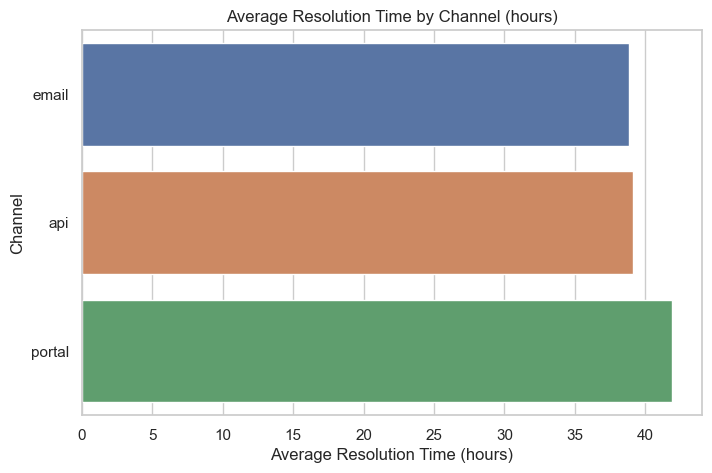

In [4]:
query = text("""
    SELECT 
        channel,
        ROUND(AVG(resolution_time_s)/3600, 2) AS avg_resolution_hours,
        COUNT(*) AS ticket_count
    FROM tickets
    WHERE resolution_time_s IS NOT NULL
    GROUP BY channel
    ORDER BY avg_resolution_hours;
""")

# Load the data into a DataFrame
with engine.connect() as conn:
    df_resolution = pd.read_sql(query, conn)

# Plot average resolution time per channel with distinct colors
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_resolution,
    x="avg_resolution_hours",
    y="channel",
    hue="channel",       
    dodge=False,         
    legend=False       
)

plt.title("Average Resolution Time by Channel (hours)")
plt.xlabel("Average Resolution Time (hours)")
plt.ylabel("Channel")
plt.show()


In [5]:
### <span style="color:#4da6ff; font-weight:bold"> TICKET COUNT PER CHANNEL

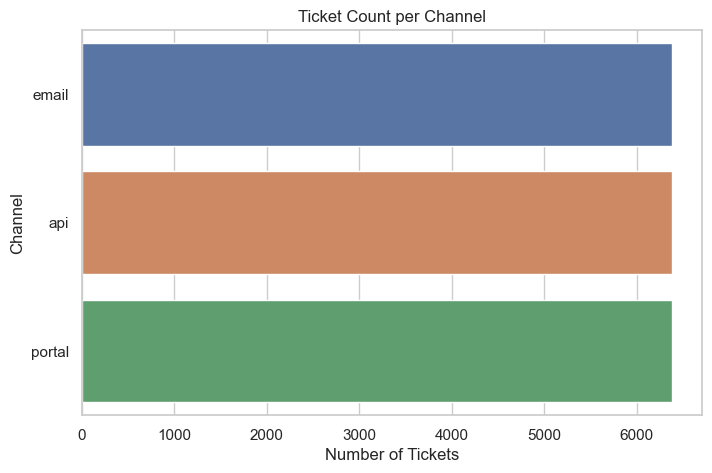

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_resolution,
    x="ticket_count",
    y="channel",
    hue="channel",
    dodge=False,
    legend=False
)
plt.title("Ticket Count per Channel")
plt.xlabel("Number of Tickets")
plt.ylabel("Channel")
plt.show()

### <span style="color:#4da6ff; font-weight:bold"> TICKET STATUS DISTRIBUTION

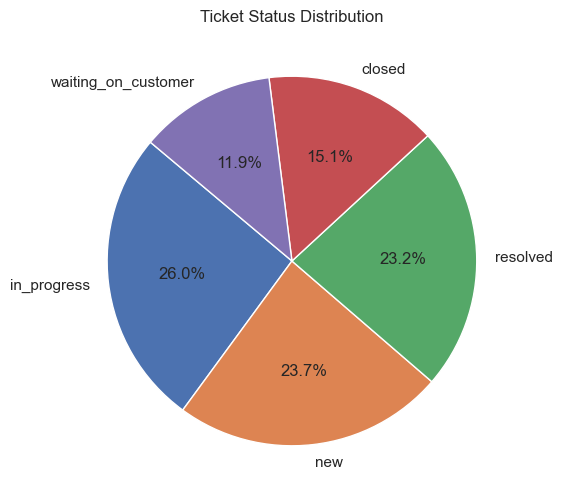

,status,ticket_count
0,in_progress,13025
1,new,11866
2,resolved,11592
3,closed,7566
4,waiting_on_customer,5952


In [7]:
query = text("""
    SELECT 
        status,
        COUNT(*) AS ticket_count
    FROM tickets
    GROUP BY status
    ORDER BY ticket_count DESC;
""")

with engine.connect() as conn:
    df_status = pd.read_sql(query, conn)

plt.figure(figsize=(6,6))
plt.pie(df_status["ticket_count"], labels=df_status["status"], autopct='%1.1f%%', startangle=140)
plt.title("Ticket Status Distribution")
plt.show()

display(df_status)


### <span style="color:#4da6ff; font-weight:bold"> TOP-10 INFORMATIVE KEYWORDS IN TICKET SUBJECTS

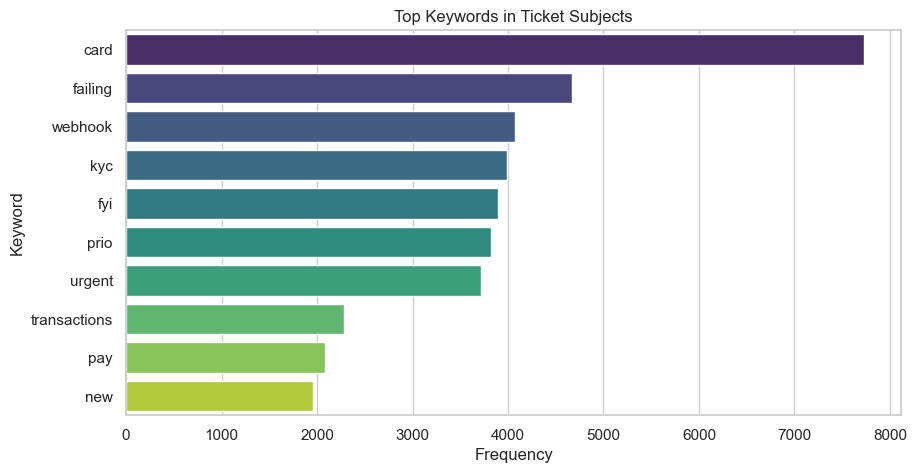

,word,count
0,card,7731
1,failing,4672
2,webhook,4069
3,kyc,3988
4,fyi,3893
5,prio,3826
6,urgent,3721
7,transactions,2277
8,pay,2087
9,new,1962


In [8]:
query = text("SELECT subject FROM tickets WHERE subject IS NOT NULL;")
with engine.connect() as conn:
    df_subjects = pd.read_sql(query, conn)

# Simple tokenization
all_words = []
for subj in df_subjects["subject"].dropna():
    tokens = re.findall(r"\b[a-zA-ZåäöÅÄÖ]+\b", subj.lower())
    all_words.extend(tokens)

# Filter out short/common words
stopwords = set(["the", "and", "of", "to", "in", "a", "for", "on", "is", "error", "issue", "problem", 
                 "with", "keeps", "how","help", "need", "can", "about", "too"])
filtered = [w for w in all_words if w not in stopwords and len(w) > 2]

common_words = Counter(filtered).most_common(10)
df_keywords = pd.DataFrame(common_words, columns=["word", "count"])

plt.figure(figsize=(10,5))
sns.barplot(data=df_keywords, x="count", y="word", palette="viridis")
plt.title("Top Keywords in Ticket Subjects")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()

display(df_keywords)


### <span style="color:#4da6ff; font-weight:bold"> AVERAGE RESOLUTION TIME BY SOURCE SYSTEM

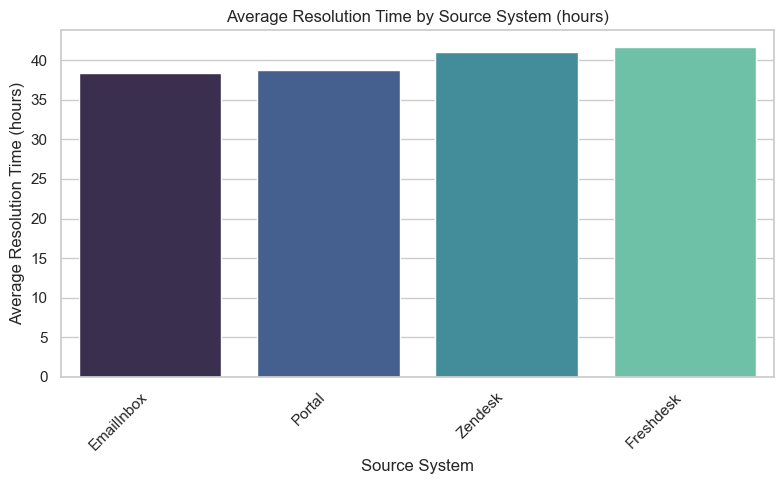

,source_system,avg_resolution_hours,ticket_count
0,EmailInbox,38.34,4762
1,Portal,38.76,4804
2,Zendesk,41.08,4828
3,Freshdesk,41.66,4764


In [9]:
query = text("""
    SELECT 
        source_system,
        ROUND(AVG(resolution_time_s)/3600, 2) AS avg_resolution_hours,
        COUNT(*) AS ticket_count
    FROM tickets
    WHERE resolution_time_s IS NOT NULL
    GROUP BY source_system
    ORDER BY avg_resolution_hours;
""")

with engine.connect() as conn:
    df_system_perf = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_system_perf,
    x="source_system",
    y="avg_resolution_hours",
    palette="mako"
)

plt.title("Average Resolution Time by Source System (hours)")
plt.xlabel("Source System")
plt.ylabel("Average Resolution Time (hours)")
plt.xticks(rotation=45, ha='right')  # rotate labels for readability
plt.tight_layout()
plt.show()

display(df_system_perf)


### <span style="color:#4da6ff; font-weight:bold"> TICKET COUNT BY LANGUAGE IN SUBJECT+ BODY

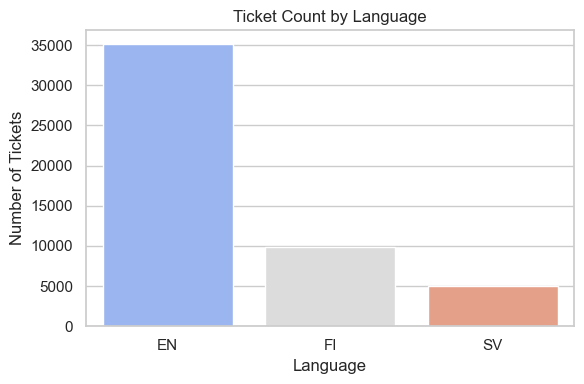

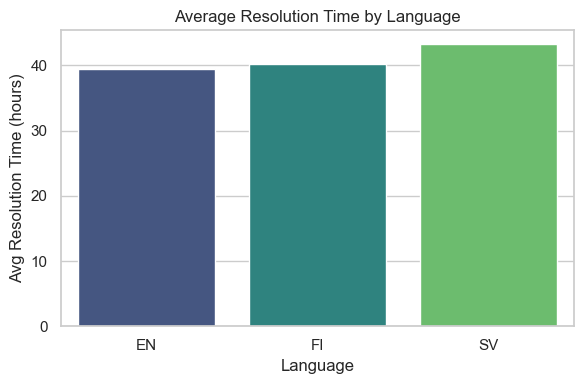

In [10]:
from langdetect import detect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import text

# Fetch tickets from DB
query = text("""
    SELECT ticket_id, subject, body, resolution_time_s
    FROM tickets
""")
df = pd.read_sql(query, engine)

# Detect language
def detect_language(row):
    text_sample = str(row["subject"]) + " " + str(row["body"])
    try:
        lang = detect(text_sample)
        if lang.startswith("en"):
            return "EN"
        elif lang.startswith("fi"):
            return "FI"
        elif lang.startswith("sv"):
            return "SV"
        else:
            return "Other"
    except:
        return "Unknown"

df["language"] = df.apply(detect_language, axis=1)

# Keep only EN, FI, SV
df = df[df["language"].isin(["EN", "FI", "SV"])]

#Ticket count per language
lang_counts = df["language"].value_counts().reset_index()
lang_counts.columns = ["language", "ticket_count"]

plt.figure(figsize=(6,4))
sns.barplot(
    data=lang_counts,
    x="language",
    y="ticket_count",
    palette="coolwarm"
)
plt.title("Ticket Count by Language")
plt.xlabel("Language")
plt.ylabel("Number of Tickets")
plt.tight_layout()
plt.show()

# Average resolution time per language (hours)
df_res = df[df["resolution_time_s"].notnull()]
avg_res_time = df_res.groupby("language")["resolution_time_s"].mean().reset_index()
avg_res_time["avg_resolution_hours"] = avg_res_time["resolution_time_s"] / 3600

plt.figure(figsize=(6,4))
sns.barplot(
    data=avg_res_time,
    x="language",
    y="avg_resolution_hours",
    palette="viridis"
)
plt.title("Average Resolution Time by Language")
plt.xlabel("Language")
plt.ylabel("Avg Resolution Time (hours)")
plt.tight_layout()
plt.show()


In [11]:
# import pandas as pd

# # Show full column content
# pd.set_option('display.max_colwidth', None)

# # Filter for Finnish tickets
# df_fi = df[df["language"] == "FI"]

# # Show rows 55 to 75 of the filtered DataFrame
# df_fi.iloc[120:150]
